# Diffusion-based Time Prediction

Simulating partial differential equations (PDEs), for example turbulent fluid flows, often requires resolving solutions over time. I.e., we're not interested
in a time-averaged or long-term equilibrium state, but the actual changes of our system over time. This requires iterative solvers that are called _auto-regressively_, 
one step after the other, to produce a solution over time. 
Despite all advancements in this area, it is still a critical challenge to achieve stable and accurate predictions for extended temporal horizons. Many dynamical systems are inherently complex and chaotic, making it difficult to faithfully capture intricate physical phenomena over long timeframes. 

At the same time, uncertainties also play a role for time series prediction:
Even minor ambiguities in the spatially averaged states used for simulations can lead to very different outcomes over time. Moreover, most traditional solvers and learning-based methods process simulation trajectories in a deterministic way, treating them as being first-order Markovian (one state fully determines the next one). 
Instead a more realistic viewpoint of many systems is given by the [Mori-Zwanzig formalism](https://en.wikipedia.org/wiki/Mori-Zwanzig_formalism): we observe a part of our system, but at the same time an "unobserved" (or un-simulated) part of the state can influence its evolution over time.
Deterministic simulators produce a single solution without accounting for a potentially probabilistic underlying processes. 
This motivates - as in the previous sections - to view the steps of a time series as a probabilistic distribution over time rather than a deterministic series of states.
A probabilistic simulator can learn to take into account the influence of the un-observed state, and infer solutions from variations of this un-observed part of the system. Worst case, if this un-observed state has a negligible influence, we should see a mean state with an variance that's effectively zero. So there's nothing to loose! 

The following notebook 
[[run in colab]](https://colab.research.google.com/github/tum-pbs/pbdl-book/blob/main/probmodels-time.ipynb)
 introduces an effective, distribution-based approach for temporal predictions:
* conditional diffusion models are used to compute autoregressive rollouts to obtain a "probabilistic simulator"; 
* it is of course highly interesting to compare this diffusion-based predictor to the deterministic baselines and neural operators from the previous chapters;
* in order to evaluate the results w.r.t. their accuracy, we'll employ a transonic fluid flow for which we can compute statistics from a simulated reference.

Problem formulation: while we've previously often focused on training networks for the task $f(x)=y$, we now focus on 
tasks of the form $f(x_{t})=x_{t+1}$ 
to indicate that any subsequent step, e.g., $f(x_{t+1})=x_{t+2}$, is a problem of the same importance as the first one.
We still have ground truth values $x^*_{t+1}$, e.g., from an expensive high-fidelity simulation, and aim for a minimization problem

$$
 \text{arg min}_{\theta} | f(x_{t};\theta) - x^*_{t+1} |_2^2 .
$$ (learn-autoreg-l2)



```{note} 
**Unconditional stability**: One of the most interesting aspects of using diffusion-based time predictors is their temporal stability. It seems that the diffusion process forces the networks to learn handling perturbations and accumulated errors in the states without being easily thrown off track. This is crucial for _unconditional stability_, i.e., neural networks that can be called autoregressively any number of times without blowing up. The training process below yields unconditionally stable networks with a surprisingly simple approach for training (we'll use DDPM below, but flow matching would likewise work).

For a more detailed evaluation of the long term stability of diffusion-based predictions [can be found here](https://ge.in.tum.de/2024/08/05/how-to-train-unconditionally-stable-autoregressive-neural-operators/).
```


## Conditioning

Previously, for the inverse problem setting we only briefly mentioned that the inference task of producing the posterior distribution depends
on a set of hyperparameters such as a chosen set of boundary conditions. Let's consider $x=(c,d)$, i.e. a data point $x$ is made up of a
component for conditioning  $c$ and the target data $d$.
For time predictions, we additionally have a strong conditioning on the current time step, i.e. $c$ will contain $x_t$ in addition to, e.g., a Reynolds number. 
Hence, this is a good occasion to explain
some of the subtleties of implementing the conditioning. The central take-away message here is: all inputs for conditioning should be treated
in the same way as the outputs of the diffusion process.

This seems somewhat counter-intuitive at first: after all, the conditioning is more similar to an input than an output. 
However, it was shown that "forcing" the network to denoise the conditioning alongside the target at training time forces
it to fully consider the conditioning variables. This leads to a tight entangling of features learned for the output with 
the conditioning. 
Removing the conditioning information at high noise levels in this way has the additional benefit of reducing error accumulation: 
Since the initial steps of the reverse process $p_\theta$ are mostly unconditional due to the very noisy conditioning, accumulated 
errors in $c$ from the previous denoising steps are not immediately included in the prediction $d$.

Thus for training we consider both parts $c$ and $d$ in the same way. This is illustrated on the left side
of the following picture. Conditioning $c$ and data components $d$ are treated the same at training time. This illustration 
denotes denoising time by $r$, to distinguish it from the time of the physical process $t$.


```{figure} resources/probmodels-time1.png
---
height: 160px
name: probmodels-time-general
---
An illustration of forward and backward noising/denoising chains with conditioning $c$ and data $d$. 
```


Once the model is trained, we make use of the fact that we know the exact value of $c$. As the noise $\epsilon$ is likewise
an input to the model that we have under full control, we can ensure that the conditioning $c_r$ at denoising time $r$ has
exactly the right content according to the chosen noise field and noising schedule. Hence we invoke $p_\theta(x_{r-1}| x_r)$
yielding  $c_{r-1}$ as well as $d_{r-1}$, both contained in $x_{r-1}$. The predicted conditioning  $c_{r-1}$ will be good
if the model $p_\theta$ was trained well, but to make sure there is zero drift we simply recompute $c_{r-1}$ from the known ground truth 
$c$ and the right noise amount $\epsilon_{r-1}$. We then invoke $p_\theta(x_{r-2}| x_{r-1})$ with $x_{r-1}$ containing
the re-computed $c$ and the $d_{r-1}$ component previously inferred in the previous denoising step.

For time prediction tasks, the situation is not anymore complicated, but slightly more confusing in terms of notation:
here, the conditioning is the previous time step in _physical_ time $x^t$. (There could be additional global parameters in $c$, but we'll
ignore those for simplicity; they can simply be appended to $c$.) The $d$ component of each denoising chain will
yield the next state of our physical system $x^{t+1}$. Thus, at denoising time, the task for our network is to 
denoise both time steps, while we prescribe the correctly noised known state at inference time: $c=x^{t}$, $d=x^{t+1}$. In the schematic from 
before, this yields:


```{figure} resources/probmodels-time2.png
---
height: 180px
name: probmodels-time2-time
---
Forward and backward chains for time prediction:
At training time, $c=x^t$ and data $d=x^{t+1}$ are treated jointly.
For inference, $c$ is overwritten with ground truth values at each iteration of the diffusion model.
```


Note that in both cases, the physics time $t$ is completely orthogonal to $r$, i.e., the denoising process does not
interact or use $t$ in any other way apart from being given the task to produce an output that obeys the dynamics of our system.
A nice variation of this approach is to use a variable time step $\Delta t$ as conditioning parameter in $c$. Below, we'll
fix $\Delta t$ and normalize it to $1$ for simplicity.


## Implementation 

Specifically, this notebook will explain _autoregressive conditional diffusion models_ ([ACDM](https://github.com/tum-pbs/autoreg-pde-diffusion)), following an existing [benchmark and paper](https://arxiv.org/abs/2309.01745). The goal is the creation of a diffusion-based architecture, that can probabilistically and accurately predict the next simulation step of a turbulent flow simulation. 

As a first step, we'll download a pre-trained model checkpoint to shorten the training time later on. This might take a few minutes. (Note: the command will not re-download files, if already downloaded successfully)

In [2]:
!mkdir -p models/
!wget -nc "https://dataserv.ub.tum.de/s/m1734798.001/download?path=/&files=checkpoints_acdm_tra.zip" -O models/checkpoints_acdm_tra.zip --no-check-certificate
!unzip -nq models/checkpoints_acdm_tra.zip -d models

File ‘models/checkpoints_acdm_tra.zip’ already there; not retrieving.


Colab already comes with a range of pre-installed packages and we only need to additionally install the *einops* package and the [PBDL-Dataloader](https://github.com/tum-pbs/pbdl-dataset). If you are running this file locally and not inside colab, follow the [installation instructions](https://github.com/tum-pbs/autoreg-pde-diffusion) instead. Afterwards, make sure that the [PBDL-Dataloader](https://github.com/tum-pbs/pbdl-dataset) is also installed via `pip install git+https://github.com/tum-pbs/pbdl-dataset@main`.

In [3]:
try:
    import google.colab  # only to ensure that we are inside colab
    %pip install einops
    %pip install git+https://github.com/tum-pbs/pbdl-dataset@main
except ImportError:
    print("This notebook is running locally, please follow the ACDM installation instructions and install the PBDL loader")
    pass

This notebook is running locally, please follow the ACDM installation instructions and install the PBDL loader


Lets import some packages that we will need in the follwing.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SequentialSampler, RandomSampler

from einops import rearrange
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

import math
import os, json
from typing import List,Tuple,Dict

from pbdl.torch.loader import Dataloader

## Backbone Network Definition

Of course, we also need a neural network architecture. Here, we will rely on a ["modern" U-Net](https://arxiv.org/abs/2006.11239). In contrast to classic U-Net from {doc}`supervised-airfoils`, this modernized version differs in a few important places:
the skip connection are replaced by attention mechanisms, _GELU_ activations replace _ReLU_, and group normalizations are employed at each layer of the U-Net. This architecture is the backbone of many popular diffusion models, and typically yields at least a few percent improvements over simpler architectures (in some cases also much more).

We start with a residual block that defines the skip connections, as well as the up- and downsampling operations of the U-Net. We will also make use of sinusoidal position embeddings from the [transformer architectures](https://arxiv.org/abs/1706.03762), to integrate the diffusion step with a time embedding MLP throughout the U-Net layers.

In [5]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

Next, this class is the core convolution block in every level of the U-Net architecture, based on the [ConvNeXtBlock](https://arxiv.org/abs/2201.03545).

In [6]:
class ConvNextBlock(nn.Module):

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if time_emb_dim is not None else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if self.mlp is not None and time_emb is not None:
            assert time_emb is not None, "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

We'll also define classes for the _attention_ mechanisms. As regular attention (also known as "softmax attention") has a quadratic scaling w.r.t. the input size, it is only applied in the bottleneck layer of the U-Net. Here we have the smallest size of the latent space, and hence the dense connectivity of the attention should not lead to resource explosions.

For the skip connections, _linear_ attention is used instead. As the name implies, it is linear in terms of input size, but still quadratic w.r.t. its internal kernel dimension. That one, however, can be chosen freely, while we're restricted to given (and potentially) large input sizes in the U-Net structure.


In [7]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = torch.einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = torch.einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

The next helper provides a convenient way to add group normalization, which we'll add before up- and down-sampling the intermediate states.

In [8]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

Putting the introduced layers together, the next cell defines the full, attention-based U-Net architecture:

In [9]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = init_dim if init_dim is not None else dim // 3 * 2
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            raise NotImplementedError()

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )

        else:
            time_dim = None
            self.time_mlp = None
            self.cond_mlp = None
            self.sim_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = out_dim if out_dim is not None else channels
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if self.time_mlp is not None else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

## Variance Schedule

To determine the noise levels over the course of the diffusion process, a noise schedule is required. Here, we will employ the simple linear schedule proposed by [Ho et al.](https://arxiv.org/abs/2006.11239), with adjusted variance parameters, such that any number of diffusion steps larger than 10 should work well:

In [10]:
def linear_beta_schedule(timesteps):
    if timesteps < 10:
        raise ValueError("Warning: Less than 10 timesteps require adjustments to this schedule!")

    beta_start = 0.0001 * (500/timesteps) # adjust reference values determined for 500 steps
    beta_end = 0.02 * (500/timesteps)
    betas = torch.linspace(beta_start, beta_end, timesteps)
    return torch.clip(betas, 0.0001, 0.9999)

## Diffusion Model Definition

Finally, we have collected all pieces to define a class containing the actual diffusion model.

We first compute the noising schedule for DDPM, and make sure the hyperparameters of the diffusion process are not treated as variables during learning (declaring them as _buffers_ in pytorch via `register_buffer`).

In [11]:
class DiffusionModel(nn.Module):
    def __init__(self, diffusionSteps:int, condChannels:int, dataChannels:int):
        super(DiffusionModel, self).__init__()

        self.timesteps = diffusionSteps
        betas = linear_beta_schedule(timesteps=self.timesteps)

        betas = betas.unsqueeze(1).unsqueeze(2).unsqueeze(3)
        alphas = 1.0 - betas
        alphasCumprod = torch.cumprod(alphas, axis=0)
        alphasCumprodPrev = F.pad(alphasCumprod[:-1], (0,0,0,0,0,0,1,0), value=1.0)
        sqrtRecipAlphas = torch.sqrt(1.0 / alphas)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        sqrtAlphasCumprod = torch.sqrt(alphasCumprod)
        sqrtOneMinusAlphasCumprod = torch.sqrt(1. - alphasCumprod)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posteriorVariance = betas * (1. - alphasCumprodPrev) / (1. - alphasCumprod)
        sqrtPosteriorVariance = torch.sqrt(posteriorVariance)

        self.register_buffer("betas", betas)
        self.register_buffer("sqrtRecipAlphas", sqrtRecipAlphas)
        self.register_buffer("sqrtAlphasCumprod", sqrtAlphasCumprod)
        self.register_buffer("sqrtOneMinusAlphasCumprod", sqrtOneMinusAlphasCumprod)
        self.register_buffer("sqrtPosteriorVariance", sqrtPosteriorVariance)

        # backbone model
        self.unet = Unet(
            dim=128,
            channels= condChannels + dataChannels,
            dim_mults=(1,1,1),
            use_convnext=True,
            convnext_mult=1,
        )


    # input shape (both inputs): B S C W H (D) -> output shape (both outputs): B S nC W H (D)
    def forward(self, conditioning:torch.Tensor, data:torch.Tensor) -> torch.Tensor:
        device = "cuda" if data.is_cuda else "cpu"
        seqLen = data.shape[1]

        # combine batch and sequence dimension for decoder processing
        d = torch.reshape(data, (-1, data.shape[2], data.shape[3], data.shape[4]))
        cond = torch.reshape(conditioning, (-1, conditioning.shape[2], conditioning.shape[3], conditioning.shape[4]))

        # TRAINING
        if self.training:

            # forward diffusion process that adds noise to data
            d = torch.concat((cond, d), dim=1)
            noise = torch.randn_like(d, device=device)
            t = torch.randint(0, self.timesteps, (d.shape[0],), device=device).long()
            dNoisy = self.sqrtAlphasCumprod[t] * d + self.sqrtOneMinusAlphasCumprod[t] * noise

            # noise prediction with network
            predictedNoise = self.unet(dNoisy, t)

            # unstack batch and sequence dimension again
            noise = torch.reshape(noise, (-1, seqLen, conditioning.shape[2] + data.shape[2], data.shape[3], data.shape[4]))
            predictedNoise = torch.reshape(predictedNoise, (-1, seqLen, conditioning.shape[2] + data.shape[2], data.shape[3], data.shape[4]))

            return noise, predictedNoise


        # INFERENCE
        else:
            # conditioned reverse diffusion process
            dNoise = torch.randn_like(d, device=device)
            cNoise = torch.randn_like(cond, device=device)

            for i in reversed(range(0, self.timesteps)):
                t = i * torch.ones(cond.shape[0], device=device).long()

                # compute conditioned part with normal forward diffusion
                condNoisy = self.sqrtAlphasCumprod[t] * cond + self.sqrtOneMinusAlphasCumprod[t] * cNoise

                dNoiseCond = torch.concat((condNoisy, dNoise), dim=1)

                # backward diffusion process that removes noise to create data
                predictedNoiseCond = self.unet(dNoiseCond, t)

                # use model (noise predictor) to predict mean
                modelMean = self.sqrtRecipAlphas[t] * (dNoiseCond - self.betas[t] * predictedNoiseCond / self.sqrtOneMinusAlphasCumprod[t])

                dNoise = modelMean[:, cond.shape[1]:modelMean.shape[1]] # discard prediction of conditioning
                if i != 0:
                    # sample randomly (only for non-final prediction), use mean directly for final prediction
                    dNoise = dNoise + self.sqrtPosteriorVariance[t] * torch.randn_like(dNoise)

            # unstack batch and sequence dimension again
            dNoise = torch.reshape(dNoise, (-1, seqLen, data.shape[2], data.shape[3], data.shape[4]))

            return dNoise

The most important function above is the `forward` step of the `DiffusionModel` class. It switches between training and inference via the `self.training` flag, and correspondingly either evaluates a single step in the Markov chain for backpropagation, or the full chain to obtain a sample at inference time. The `c` and `d` prefixes of the variables indicate the distinction between _conditioning_ and _data_ components in $x$, as explained above. E.g., an important line in the inference code is `dNoiseCond=concat(condNoisy, dNoise)` this gives an $x$ by concatenating conditioning and data. Both parts of the $x$ are jointly denoised, and the conditioning part is removed after network execution via `modelMean[:, cond.shape[1]:modelMean.shape[1]]`. It's overwritten with the ground truth conditioning, such that the diffusion model can focus on producing an accurate `d` part.

---

In the cell below we'll use the `PBDL-Dataloader` class to obtain the training (and testing) dataset. The code below first cleans up (`del`-eting old loaders that might stick around, this is useful for working in Jupyter to avoid HDF5 file lock errors).

A slight complication here is that we'll only use a small part of the full dataset (3 simulations with IDs 20,21 for training and 22 for testing). To make sure we have the right normalization constants for the full dataset (and to spare you the time to download all the full 5GB), the `norm_X_mean` and `norm_X_std` fields of the dataloader are manually initialized with the constants from the full dataset below.

In [12]:
# delete loaders if existing to ensure the dataset file is acessible
try:
    del trainLoader
except:
    pass
try:
    del testLoader
except:
    pass

# adjust dataset normalization buffers to match data normalization of pretrained model
download = Dataloader("transonic-cylinder-flow", sel_sims=[20,21,22])
del download
import h5py
dataPath = "datasets/transonic-cylinder-flow.hdf5"
with h5py.File(dataPath, "r+") as f:
    if "norm_fields_sca_mean" in f:
        f.__delitem__("norm_fields_sca_mean")
    if "norm_fields_sca_std" in f:
        f.__delitem__("norm_fields_sca_std")
    if "norm_const_mean" in f:
        f.__delitem__("norm_const_mean")
    if "norm_const_std" in f:
        f.__delitem__("norm_const_std")

    f["norm_const_mean"] = np.array([0.70])
    f["norm_const_std"] = np.array([0.118322])
    f["norm_fields_sca_mean"] = np.array([[[0.560642]], [[-0.000129]], [[0.903352]], [[0.637941]]])
    f["norm_fields_sca_std"] = np.array([[[0.216987]], [[0.216987]], [[0.145391]], [[0.119944]]])
    f.close()


batch = 32 # training batch size

# training set configuration
trainLoader = Dataloader(
    "transonic-cylinder-flow",
    time_steps=5, # leads to six timesteps that are later strided by a factor of 2 (for dt compatibility with pre-trained model with two input steps and one target step)
    intermediate_time_steps=True,
    step_size=6, # discard some datasamples close together
    sel_sims=[20, 21], # select simulations
    trim_start=250, # discard some initial timesteps from the simulation
    normalize_data="mean-std", # data normalization
    normalize_const="mean-std", # constants normalization
    batch_size=batch,
    shuffle=True,
    drop_last=True,
    num_workers=2,
)

download completed	 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100%6m
Success: Loaded transonic-cylinder-flow with 41 simulations (3 selected) and 1 samples each.
download completed	 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100%6m
Success: Loaded transonic-cylinder-flow with 41 simulations (2 selected) and 124 samples each.


## Training

With all these building blocks and data available now, its time put them together and train the diffusion model. You can choose to either continue training for a few epochs from the provided model checkpoint (takes less than a minute for 10 epochs), or train the model from scratch on the small exemplary data set (this will take a few hours). Note that the prediction quality and diversity for training the model from scratch will be noticeably worse, due to limited amount of data available here.

Feel free to skip this step entirely, if you don't want to train the network. You can directly continue with the sampling below, by using the pre-trained checkpoint.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Training device: %s" % device)

startFromCheckpoint = True

if startFromCheckpoint:
    epochs = 10 # finetune only for a small number of epochs
    lr = 0.00001 # since the model is already trained, a conservatively low learning rate
else:
    epochs = 100000 # train from scratch for large number of epochs, this will take a while
    lr = 0.0001 # larger learning rate for training from scratch

diffusionSteps = 20 # the provided model checkpoint was pretrained on 20 diffusion steps

# model definition
condChannels = 2 * 5 # two timesteps with 5 channels each (vel_x, vel_y, dens, pres, mach)
dataChannels = 5 # one timestep
model = DiffusionModel(diffusionSteps, condChannels, dataChannels)

if startFromCheckpoint:
    # load weights from checkpoint
    loaded = torch.load("models/models_tra/128_acdm-r20_02/Model.pth", map_location=torch.device('cpu'))
    model.load_state_dict(loaded["stateDictDecoder"])
model.train()
model.to(device)

# print model info and trainable weigths
paramsTrainable = sum([np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters())])
params = sum([np.prod(p.size()) for p in model.parameters()])
#print(model)
print("Trainable Weights (All Weights): %d (%d)" % (paramsTrainable, params))

# training loop
print("\nStarting training...")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for epoch in range(epochs):
    losses = []
    for s, sample in enumerate(trainLoader, 0):
        optimizer.zero_grad()

        input, target = sample
        input = input.unsqueeze(1) # add timestep dimension
        mach = input[:,:,-1:].expand(-1, target.shape[1], -1, -1, -1) # extract mach number from input
        target = torch.concat([target, mach], dim=2) # add mach number to target
        d = torch.concat([input,target], dim=1).to(device).float() # combined [batch, timesteps, channels, x, y] tensor
        d = d[:,::2] # temporal stride of 2 for dt compatiblity with pre-trained model

        inputSteps = 2
        cond = []
        for i in range(inputSteps):
            cond += [d[:,i:i+1]] # collect input steps
        conditioning = torch.concat(cond, dim=2) # combine along channel dimension
        data = d[:, inputSteps:inputSteps+1]

        noise, predictedNoise = model(conditioning=conditioning, data=data)

        loss = F.smooth_l1_loss(noise, predictedNoise)
        print("    [Epoch %2d, Batch %4d]: %1.7f" % (epoch, s, loss.detach().cpu().item()))
        loss.backward()

        losses += [loss.detach().cpu().item()]

        optimizer.step()
    print("[Epoch %2d, FULL]: %1.7f" % (epoch, sum(losses)/len(losses)))

del trainLoader # delete to ensure file access
print("Training complete!")

Training device: cuda


/tmp/ipykernel_917142/3219208168.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load("models/models_tra/128_acdm-r20_02/Model.pth", map_location=torch.d

Trainable Weights (All Weights): 6994035 (6994035)

Starting training...
    [Epoch  0, Batch    0]: 0.0019515
    [Epoch  0, Batch    1]: 0.0019654
    [Epoch  0, Batch    2]: 0.0008050
    [Epoch  0, Batch    3]: 0.0006933
    [Epoch  0, Batch    4]: 0.0009360
    [Epoch  0, Batch    5]: 0.0018654
    [Epoch  0, Batch    6]: 0.0016832
[Epoch  0, FULL]: 0.0014143
    [Epoch  1, Batch    0]: 0.0011901
    [Epoch  1, Batch    1]: 0.0018340
    [Epoch  1, Batch    2]: 0.0007823
    [Epoch  1, Batch    3]: 0.0014465
    [Epoch  1, Batch    4]: 0.0011019
    [Epoch  1, Batch    5]: 0.0012040
    [Epoch  1, Batch    6]: 0.0007916
[Epoch  1, FULL]: 0.0011929
    [Epoch  2, Batch    0]: 0.0008890
    [Epoch  2, Batch    1]: 0.0013503
    [Epoch  2, Batch    2]: 0.0011220
    [Epoch  2, Batch    3]: 0.0009489
    [Epoch  2, Batch    4]: 0.0010360
    [Epoch  2, Batch    5]: 0.0012546
    [Epoch  2, Batch    6]: 0.0009530
[Epoch  2, FULL]: 0.0010791
    [Epoch  3, Batch    0]: 0.0009957
    [Ep

## Test Dataset

Next we download a test dataset to make sure we can evaluate the trained network on new data. Here, we only use sequences from the data set with a different mach number and physical time than the training data above (the simulation with ID 22, which should correspond to a larger Mach number than the ones used for training with $\text{Ma}=0.72$).


In [14]:
# delete loaders if existing to ensure the dataset file is acessible
try:
    del trainLoader
except:
    pass
try:
    del testLoader
except:
    pass

# test set configuration
testLoader = Dataloader(
    "transonic-cylinder-flow",
    time_steps=119, # leads to 120 timesteps that are later strided by a factor of 2 (for dt compatibility with pre-trained model)
    intermediate_time_steps=True,
    step_size=120,
    sel_sims=[22], # select simulations
    trim_start=600, # discard some initial timesteps from the simulation
    normalize_data="mean-std", # data normalization
    normalize_const="mean-std", # constants normalization
    batch_size=1,
    shuffle=False,
    drop_last=False,
    num_workers=0,
)

download completed	 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100%6m
Success: Loaded transonic-cylinder-flow with 41 simulations (1 selected) and 2 samples each.


## Test Inference

We can now sample the trained diffusion model to create probabilistic predictions for a test set of flow trajectories. We store both predictions and ground truth in tensors with shape $(samples \times sequences \times sequenceLength \times channels \times sizeX \times sizeY)$, that are used for the evaluations and visualization below.

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

numSamples = 5
diffusionSteps = 20

try: # load model if not trained/finetuned above
    model
except NameError:
    condChannels = 2 * 5 # two timesteps with 5 channels each (vel_x, vel_y, dens, pres, mach)
    dataChannels = 5 # one timestep
    model = DiffusionModel(diffusionSteps, condChannels, dataChannels)

    # load weights from checkpoint
    loaded = torch.load("models/models_tra/128_acdm-r20_02/Model.pth", map_location=torch.device('cpu'))
    model.load_state_dict(loaded["stateDictDecoder"])
model.eval()
model.to(device)

# sampling loop
print("\nStarting sampling...")
gt = []
pred = []
with torch.no_grad():
    for s, sample in enumerate(testLoader, 0):

        input, target = sample
        input = input.unsqueeze(1) # add timestep dimension
        mach = input[:,:,-1:].expand(-1, target.shape[1], -1, -1, -1) # extract mach number from input
        target = torch.concat([target, mach], dim=2) # add mach number to target
        data = torch.concat([input,target], dim=1).to(device).float() # combined [batch, timesteps, channels, x, y] tensor
        data = data[:,::2] # temporal stride of 2 for dt compatiblity with pre-trained model

        gt += [data.unsqueeze(0).cpu().numpy()]
        d = data.to(device).repeat(numSamples,1,1,1,1) # reuse batch dim for samples

        prediction = torch.zeros_like(d, device=device)
        inputSteps = 2

        for i in range(inputSteps): # no prediction of first steps
            prediction[:,i] = d[:,i]

        for i in range(inputSteps, d.shape[1]):
            cond = []
            for j in range(inputSteps,0,-1):
                cond += [prediction[:, i-j : i-(j-1)]] # collect input steps
            cond = torch.concat(cond, dim=2) # combine along channel dimension

            result = model(conditioning=cond, data=d[:,i-1:i]) # auto-regressive inference
            result[:,:,-1:] = d[:,i:i+1,-1:] # replace mach number prediction with true values
            prediction[:,i:i+1] = result

        prediction = torch.reshape(prediction, (numSamples, -1, d.shape[1], d.shape[2], d.shape[3], d.shape[4]))
        pred += [prediction.cpu().numpy()]
        print("  Sequence %d finished" % s)


print("Sampling complete!\n")

gt = np.concatenate(gt, axis=1)
pred = np.concatenate(pred, axis=1)

print("Ground truth and prediction tensor with shape:")
print("(samples, sequences, sequenceLength, channels, sizeX, sizeY)")
print("GT: %s" % str(gt.shape))
print("Prediction: %s" % str(pred.shape))


Starting sampling...
  Sequence 0 finished
  Sequence 1 finished
Sampling complete!

Ground truth and prediction tensor with shape:
(samples, sequences, sequenceLength, channels, sizeX, sizeY)
GT: (1, 2, 60, 5, 128, 64)
Prediction: (5, 2, 60, 5, 128, 64)


## Accuracy of the Prediction

After the sampling, we can analyze the ground truth flow trajectory and the samples generated by ACDM. Let's start with a direct visualization of the predictions for a qualitative check.

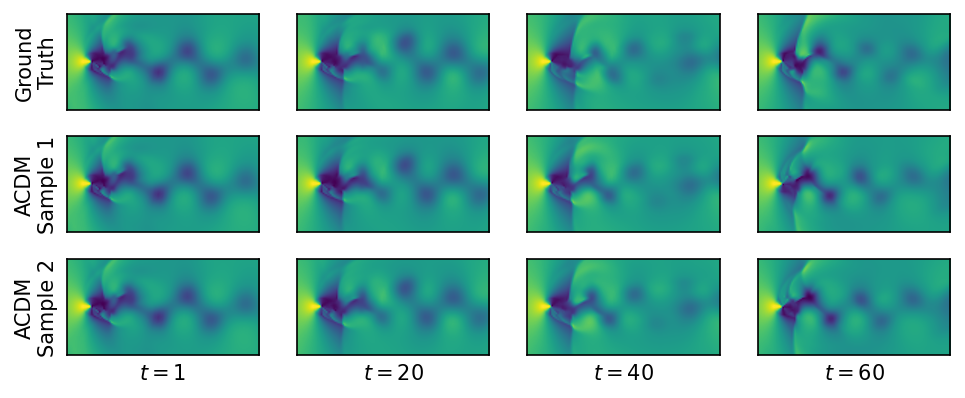

In [16]:
sequence = 0
samples = [0,4]
timeSteps = [0,19,39,59]
field = 3 # velocity_x (0), velocity_y (1), density (2), or pressure (3)

predPart = pred[samples]
gtPred = np.concatenate([gt[:,sequence,timeSteps,field], predPart[:,sequence,timeSteps,field]])

fig, axs = plt.subplots(nrows=gtPred.shape[0], ncols=gtPred.shape[1], figsize=(gtPred.shape[1]*1.9, gtPred.shape[0]), dpi=150, squeeze=False)

for i in range(gtPred.shape[0]):
    for j in range(gtPred.shape[1]):
        if i == gtPred.shape[0]-1:
            axs[i,j].set_xlabel("$t=%s$" % (timeSteps[j]+1), fontsize=10)
        if j == 0:
            if i == 0:
              axs[i,j].set_ylabel("Ground\nTruth", fontsize=10)
            else:
              axs[i,j].set_ylabel("ACDM\nSample %d" % i, fontsize=10)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        im = axs[i,j].imshow(gtPred[i][j].transpose(), interpolation="catrom", cmap="viridis")

plt.show()

The trained time operator closely matches early states, but you should be able to see variations for the last states at $t=60$. The shock waves for the cylinder are highly unstable, and hence give the network to create realistic but varying predictions. Re-running inference with different noise values will produce additional variations, and longer rollouts will further increase differences.

### Temporal Stability

We also investigate the temporal stability of the samples by computing a temporal derivative, and comparing the result to the simulation. Note that the result will be smoother, the more sequences and samples are used. Furthermore, better results can be achieved with additional training data. Naturally, the ACDM posterior samples should exhibit a larger variance compared to the individual simulation trajectories.


<>:19: SyntaxWarning: invalid escape sequence '\V'
<>:19: SyntaxWarning: invalid escape sequence '\V'
/tmp/ipykernel_917142/1134808229.py:19: SyntaxWarning: invalid escape sequence '\V'
  ax.set_ylabel("$\Vert \, (s^{t} - s^{t-1}) / \Delta t \, \Vert_1$")


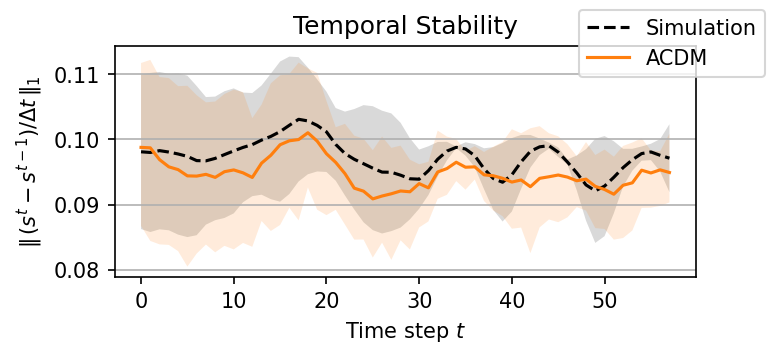

In [17]:
gtTemp = gt[:,:,:,0:4] # ignore scalar Mach number here
predTemp = pred[:,:,:,0:4]

diffGt = np.abs( gtTemp[:,:,1:gtTemp.shape[2]-1] - gtTemp[:,:,2:gtTemp.shape[2]])
diffGt = np.mean(diffGt, axis=(3,4,5)) # channel-wise and spatial mean
minGt = np.min(diffGt, axis=(0,1)) # lower bound over sequences
maxGt = np.max(diffGt, axis=(0,1)) # upper bound over sequences
meanGt = np.mean(diffGt, axis=(0,1)) # sample- and sequence mean

diffPred = np.abs( predTemp[:,:,1:predTemp.shape[2]-1] - predTemp[:,:,2:predTemp.shape[2]])
diffPred = np.mean(diffPred, axis=(3,4,5)) # channel-wise and spatial mean
minPred = np.min(diffPred, axis=(0,1)) # lower bound over samples and sequences
maxPred = np.max(diffPred, axis=(0,1)) # upper bound over samples and sequences
meanPred = np.mean(diffPred, axis=(0,1)) # sample- and sequence mean


fig, ax = plt.subplots(1, figsize=(5,2), dpi=150)
ax.set_title("Temporal Stability")
ax.set_ylabel("$\Vert \, (s^{t} - s^{t-1}) / \Delta t \, \Vert_1$")
ax.yaxis.grid(True)
ax.set_xlabel("Time step $t$")

ax.plot(np.arange(meanGt.shape[0]), meanGt, color="k", label="Simulation", linestyle="dashed")
ax.fill_between(np.arange(meanGt.shape[0]), minGt, maxGt, facecolor="k", alpha=0.15)

ax.plot(np.arange(meanPred.shape[0]), meanPred, color="tab:orange", label="ACDM")
ax.fill_between(np.arange(meanPred.shape[0]), minPred, maxPred, facecolor="tab:orange", alpha=0.15)

fig.legend()
plt.show()

### Spectral Analysis

Finally, let's compute a frequency analysis on a point downstream of the cylinder and compare the spectra of ground truth and ACDM prediction.

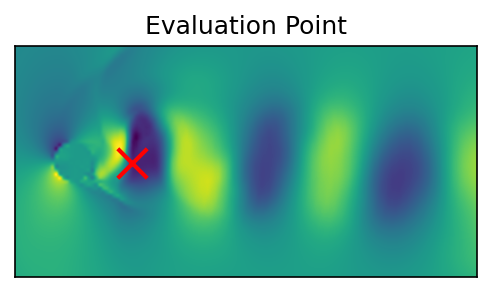

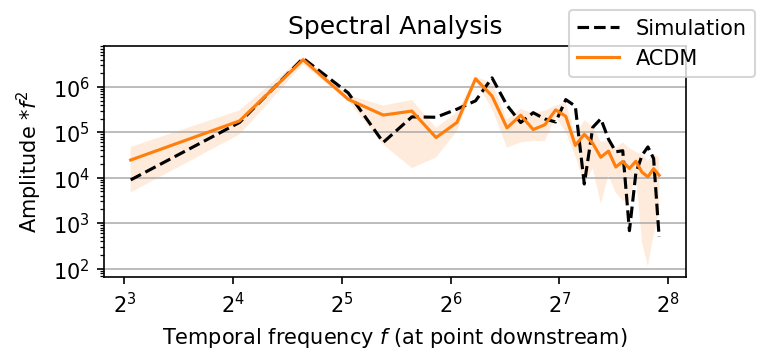

In [18]:
sequence = 0
fracX = 0.25 # closely behing the cylinder
fracY = 0.5 # vertically centered
field = 1 # velocity_x (0), velocity_y (1), density (2), or pressure (3)

posX = int(fracX * gt.shape[4])
posY = int(fracY * gt.shape[5])

gtPred = np.concatenate([gt[:,sequence,:,field, posX, posY], pred[:,sequence,:,field, posX, posY]])

fft = np.fft.fft(gtPred, axis=1)
fft = np.real(fft * np.conj(fft))
n = fft.shape[1]
gridSpacing = 0.002 # delta t between frames from simulation
freq = np.fft.fftfreq(n, d=gridSpacing)[1:int(n/2)]
fft = fft[:,1:int(n/2)] # only use positive fourier frequencies

gtFFT = fft[0]
minPredFFT = np.min(fft[1:], axis=0) # lower bound over samples
maxPredFFT = np.max(fft[1:], axis=0) # upper bound over samples
meanPredFFT = np.mean(fft[1:], axis=0) # sample mean


# plot eval point
fig, ax = plt.subplots(1, figsize=(5,2), dpi=150)
ax.set_title("Evaluation Point")
ax.imshow(gt[0,sequence,0,field].transpose(), interpolation="catrom", cmap="viridis")
ax.scatter(posX, posY, s=200, color="red", marker="x", linewidth=2)
ax.set_xticks([])
ax.set_yticks([])
plt.show()


# plot spectral analysis
fig, ax = plt.subplots(1, figsize=(5,2), dpi=150)
ax.set_title("Spectral Analysis")
ax.set_xlabel("Temporal frequency $f$ (at point downstream)")
ax.set_ylabel("Amplitude $*f^2$")
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10) # NOTE: y-axis values are not physical as data normalization is not reversed
ax.yaxis.grid(True)

ax.plot(freq, gtFFT * (freq**2), color="k", label="Simulation", linestyle="dashed")

ax.plot(freq, meanPredFFT * (freq**2), color="tab:orange", label="ACDM")
ax.fill_between(freq, minPredFFT * (freq**2), maxPredFFT * (freq**2), facecolor="tab:orange", alpha=0.15)

fig.legend()
plt.show()

The plot of the spectrum shows how the trained ACDM network matches the ground truth simulation (dashed black line) both in the low- and high-frequency domain. The simulation has a few downward spikes at the end which are mostly smoothed out by the learned predictor, but it captures the statistics of the ground truth very well.

## Summarizing Time Predictions with Diffusion Models

To conclude the results from above, this code has yielded a probabilistic model for time predictions of PDEs. The great thing about it is that it estimates the changes and uncertainties in the dataset in order to reproduce it at inference time. Hence it provides posterior sampling over time, and can be run multiple times to infer different possible solutions.

The flip side here is that diffusion models are generally not better at predicting the mean solution than classic methods [(see the ACDM benchmark for detailed evaluations)](https://github.com/tum-pbs/autoreg-pde-diffusion). Thus, if the input-output relationship in your data is unique, diffusion models will not pay off, and only incur higher inference computations. This holds for the networks above: they are more expensive, and are run repeatedly to produce a single sample. This could be sped up more (e.g. with flow matching, the model above uses denoising), but a certain (small) factor will remain.

Nonetheless, for most non-trivial datasets diffusion models will pay off: ambiguities in the data will **not be averaged out**, but treated (and reproduced) as a **distribution**.
In addition, as hinted at mentioned above, a highly interesting aspect of the diffusion-based time prediction is its **unconditional stability**.
Given an appropriate learning task, the trained models do not blow up over time or transform the input into trivial steady states. Both cases are common 
in models trained with other training methodologies. Rather, the diffusion-based networks can retain the statistics of
the reference data over arbitrarily long rollouts. It's difficult to prove that they _never_ diverge, but in our
tests stable networks did not diverge over the course of several hundred thousand rollout steps. This is a highly
attractive behavior, and indicates a fundamentally different behavior of diffusion-based models. In the next chapter
we'll provide more details, and investigate it in comparison with temporal _unrolling_. 

 